# RNA-Seq Analysis Training Demo

## Overview

This tutorial will show you the following workflow that is used to generate the list of differentially expressed genes. Running the code in this tutorial should take approximately 15 minutes.

This overflow centers roughly around the useage of the deseq2 package. Documentation for this package can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html

![RNA-Seq workflow](images/count-workflow.png)

In [ ]:
# Download Miniforge ##NOT RUN
system('curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh', intern = TRUE)

# Install Miniforge ##NOT RUN
system('bash Miniforge3-$(uname)-$(uname -m).sh -b -u -p $HOME/miniforge', intern = TRUE)

# Add Miniforge bin to the system path ##NOT RUN
Sys.setenv(PATH = paste(Sys.getenv("HOME"), "/miniforge/bin:", Sys.getenv("PATH"), sep = ""))

In [ ]:
# Install gsutil and dependencies using mamba ##NOT RUN
system('mamba install -y -c conda-forge -c bioconda gsutil', intern = TRUE)

### STEP 1: Library Installation

First install the R packages that will be used. <strong>This installation may take around 30 minutes.</strong>

In [ ]:
# Install BiocManager if not installed ##NOT RUN
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Set repositories
options(repos = BiocManager::repositories())

# Install Bioconductor packages
BiocManager::install(c("ComplexHeatmap", "DESeq2", "EnhancedVolcano"), force = TRUE)

# Install CRAN packages
install.packages(c("dplyr", "pheatmap", "ggrepel", "ggfortify"), dependencies = TRUE)

In [18]:
# Install CRAN packages - This was UPDATED AND RUN
install.packages(c("dplyr", "pheatmap", "ggrepel", "ggfortify"), dependencies = False)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
# Load libraries
library(DESeq2)
library(dplyr)
library(ComplexHeatmap)
library(EnhancedVolcano)
library(ggplot2)
library(ggrepel)
library(ggfortify)

### STEP 2: Reading in Data

This step retrieve the Merged Read counts from all samples of Bioproject PRJNA892075, and the feature table, from S3 Bucket. This step involves reformatting or adjusting the data.

To make things easier, we created a matrix, or a table, of just our read-count data -- excluding the non-numerical metadata columns. This makes it easy for us to feed this table into the deseq2 tool later on.

Additionally, later on we will use normalization involving logarithms. So, to prevent errors, we will replace all readcount values of '0' in our data, with '1'. This will change the data only slightly, and will prevent these zeroes from causing an 'undefined' or 'N/A' math error in the logarithm normalization step.


In [2]:
# Check if the directories exist before creating them
if (!dir.exists("data/gene_counts")) {
  dir.create("data/gene_counts", recursive = TRUE)
}

if (!dir.exists("data/reference")) {
  dir.create("data/reference", recursive = TRUE)
}

# Path to the gene counts file
system("wget -P data/gene_counts/ https://sra-data-athena.s3.amazonaws.com/readcounts/merged_gene_counts.txt")
system("wget -P data/reference/ https://sra-data-athena.s3.amazonaws.com/reference/mouse_feature_table.txt")

counts_file <- "data/gene_counts/merged_gene_counts.txt"
feature_table<- "data/reference/mouse_feature_table.txt"

In [4]:
#read-in the raw gene count file to a dataframe variable we named 'read_counts'
read_counts <- read.table('data/gene_counts/merged_gene_counts.txt',head=TRUE) #updated path

#amount of columns the dataframe has
cols = ncol(read_counts)

#assign the numerical read counts to a matrix variable we named 'rnaseqMatrix'
rnaseqMatrix <- round(read_counts[,c(2:cols)])

#label the rownames of this matrix with the rowname column from the gene count dataframe.
rownames(rnaseqMatrix) <- read_counts[,1]

head(rnaseqMatrix)

,GSM6658439,GSM6658438,GSM6658435,GSM6658441,GSM6658433,GSM6658431,GSM6658429,GSM6658427
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,4569,3083,3009,3806,6170,5161,3356,3267
ENSMUSG00000000003,0,0,0,0,0,0,0,0
ENSMUSG00000000028,124,94,93,124,137,143,67,68
ENSMUSG00000000031,2243,1375,1828,3267,941,496,313,322
ENSMUSG00000000037,57,26,38,33,46,49,36,26
ENSMUSG00000000049,8,0,1,0,3,0,1,1


### STEP 3: Specifying Experimental Design

Next specify the experimental design. 

The deseq2 tool will later use this design to group samples together, and output information about the statistical differences in gene expression between these specified groups.

In [5]:
# define the sample experimental design, in this case 3 wildtype and 3 bacteriophage infected samples
samples_treatment <- data.frame(matrix(c(rep("pAd PSAP",2),rep("pAd GFP",2)),ncol=1))
samples_ID <- data.frame(matrix(colnames(rnaseqMatrix),ncol=1))
samples <- cbind(samples_ID,samples_treatment)
names(samples) <- c("ID","Treatment")
rownames(samples) <- samples[,1]

print("An example of how a deseq2 experimental design table might look.")
samples



[1] "An example of how a deseq2 experimental design table might look."


,ID,Treatment
,<chr>,<chr>
GSM6658439,GSM6658439,pAd PSAP
GSM6658438,GSM6658438,pAd PSAP
GSM6658435,GSM6658435,pAd GFP
GSM6658441,GSM6658441,pAd GFP
GSM6658433,GSM6658433,pAd PSAP
GSM6658431,GSM6658431,pAd PSAP
GSM6658429,GSM6658429,pAd GFP
GSM6658427,GSM6658427,pAd GFP


### STEP 4: Creating Deseq2 Object

Now use the treatment design matrix in combination with the readcount matrix to create a deseq2 object. 

Once created, this is also a good opportunity to filter out lowly expresseed genes, and to inspect the pre-normalized data using pairwise comparison plots. These example plots, the pairwise plot and boxplot, can be used to examine gene expression distributions and highlight outliers.

Finally, the deseq2 analysis can be run on the deseq2 object.

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



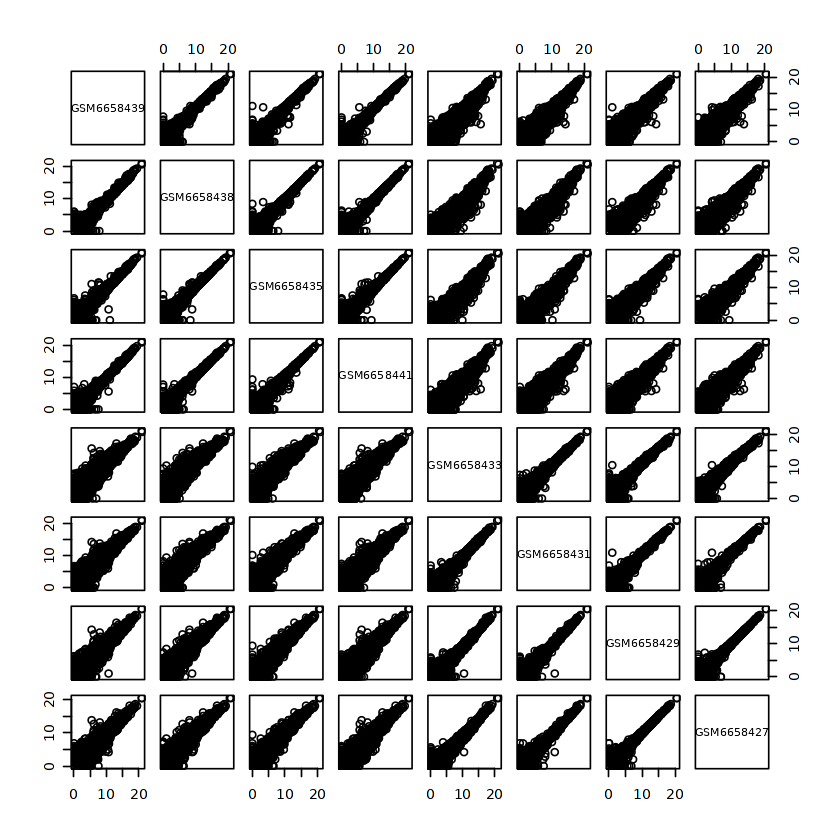

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



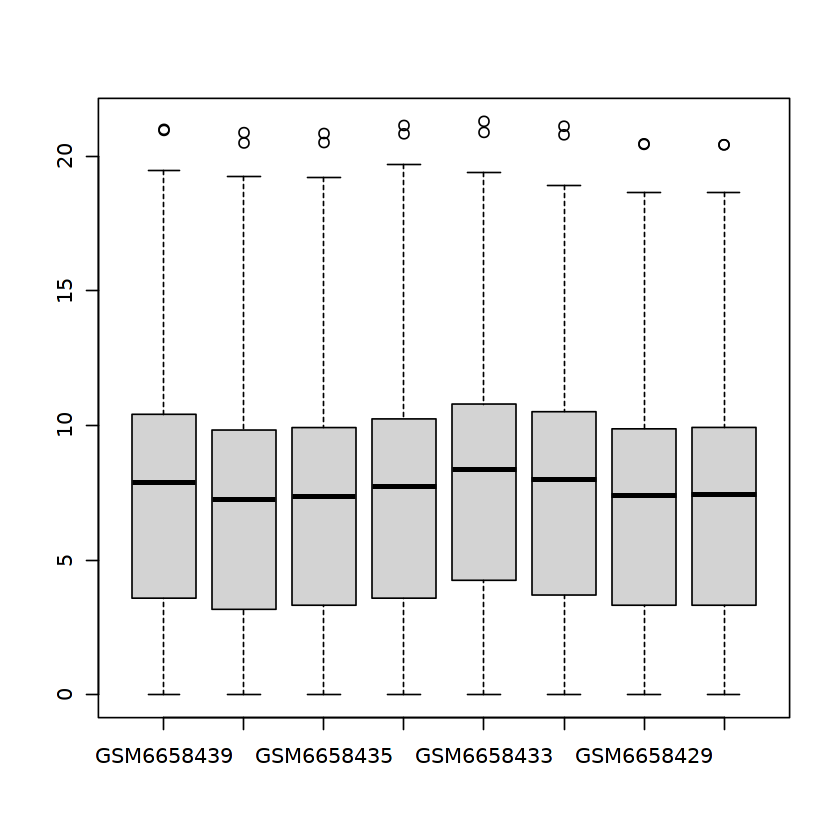

In [6]:
#Create the DEseq2DataSet object
deseq2Data <- DESeqDataSetFromMatrix(countData = rnaseqMatrix, colData = samples, design = ~ Treatment)

# Perform pre-filtering of the data (deseq2 also automatically does this, but can this can increase speed)
deseq2Data <- deseq2Data[rowSums(counts(deseq2Data)) > 10, ]

# Inspect pre-normalized data 
pairs(log2((counts(deseq2Data)+1)))
boxplot(log2((counts(deseq2Data)+1)))

# Run pipeline for differential expression steps
deseq2Data <- DESeq(deseq2Data)


### STEP 5: Normalize Data

DESeq2 automatically normalizes data in the DESeq() step using a method called median of ratios. For our own downstream analysis we can pick from several different normalization methods. As an example, here we use rlog transformation, or regularized log transformation to normalize data. This method is similar to log normalization, but includes a 'shrinkage' estimator to attempt to shrink the variance of the log-transformed data. More information for this and other normalization methods can be found in the DESeq2 documentation. 

Normalization of gene readcounts across samples will help to minimize sample variation noise and ensure more accurate comparisons. Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data. 

In [7]:
#perform rlog normalization on deseq2 object
rld <- rlog(deseq2Data, blind=FALSE)

#a handy variable so we can easily reference the rlog genecount matrix in the future, as deseq objects contain many tables of data.
rlogcounts <- assay(rld)
rownames(rlogcounts) <- rownames(deseq2Data)

head(rlogcounts)

,GSM6658439,GSM6658438,GSM6658435,GSM6658441,GSM6658433,GSM6658431,GSM6658429,GSM6658427
ENSMUSG00000000001,11.9266980,11.9278718,11.8600955,11.8637560,11.9639938,11.9875425,11.9864763,11.9327914
ENSMUSG00000000028,6.6948620,6.7669778,6.7275868,6.7645574,6.5984301,6.7511612,6.5568211,6.5463090
ENSMUSG00000000031,10.5713991,10.4813296,10.7010057,11.0444236,9.5916007,9.2698072,9.2549761,9.2508247
ENSMUSG00000000037,5.3419614,5.1854552,5.3107915,5.1675764,5.1515181,5.2542848,5.3020131,5.1672099
ENSMUSG00000000049,0.7114929,0.5939881,0.6143584,0.5922462,0.6283709,0.5913573,0.6151061,0.6143673
ENSMUSG00000000056,11.7273066,11.7803340,11.7291243,11.6741138,11.6258873,11.7629792,11.7519118,11.7941186


Normalization of data can is often verified by inspecting by various plots, such as histograms (these typically follow a negative binomial distribution, as shown below):

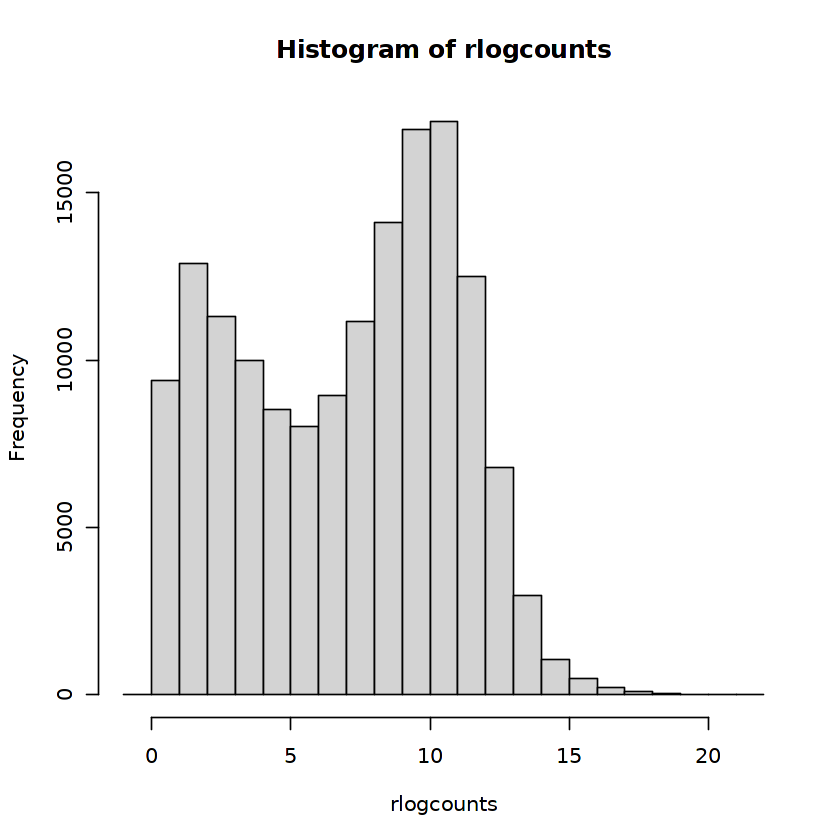

In [8]:
hist(rlogcounts)

Boxplots:

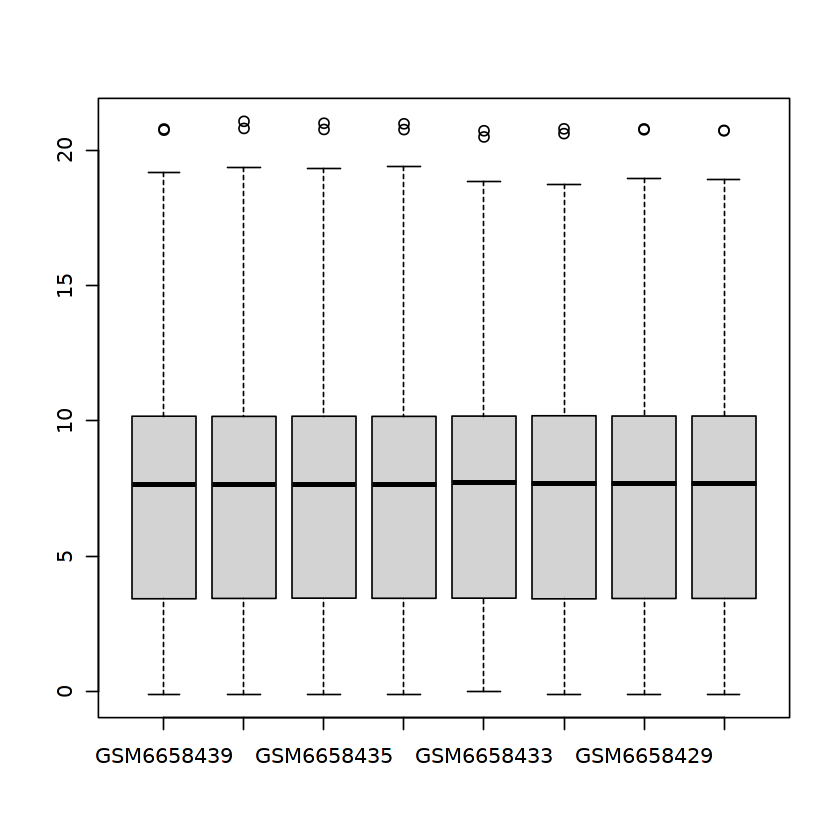

In [9]:
boxplot(rlogcounts)

Or pairwise comparison plots. Notice how sample groups can be visualized just by looking at the pairwise plot.

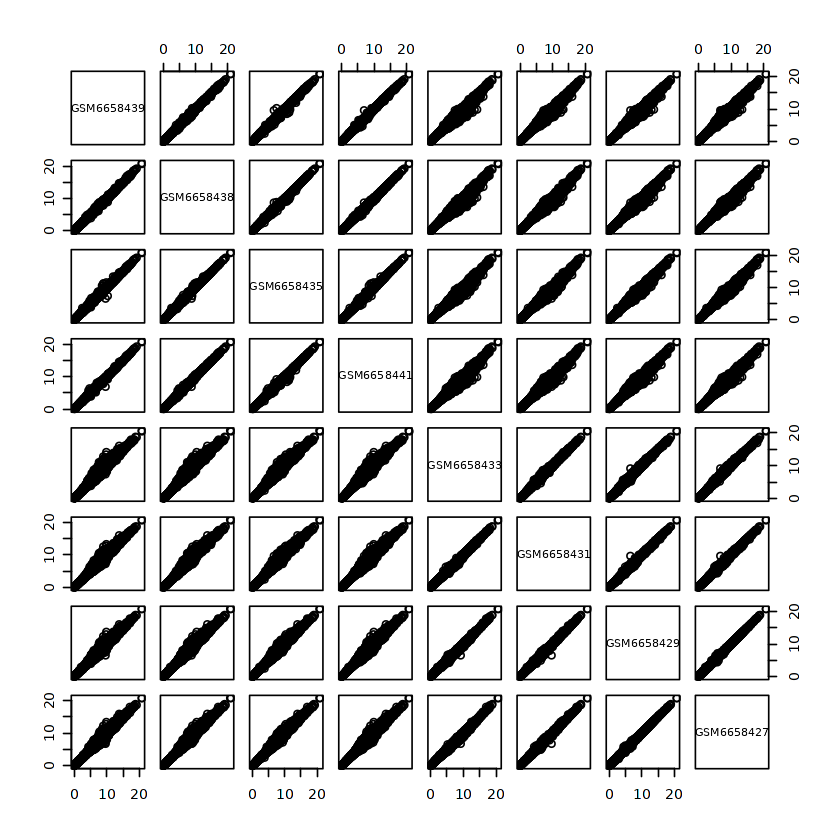

In [10]:
pairs(rlogcounts)

Compare the plots of the pre-normalized and normalized data to see the effect of normalization.

Notice how the samples in the box plot, and in-group samples in the pair plots display similar distributions.

Looking at normalized plots can be an easy way to look out for any obvious inconsistencies or errors in the sample data.

### STEP 6: PCA Plot

We can now begin to produce plots to further analyze the differences between groups.

PCA plots can be an effective way to visualize variation within and between sample sets.

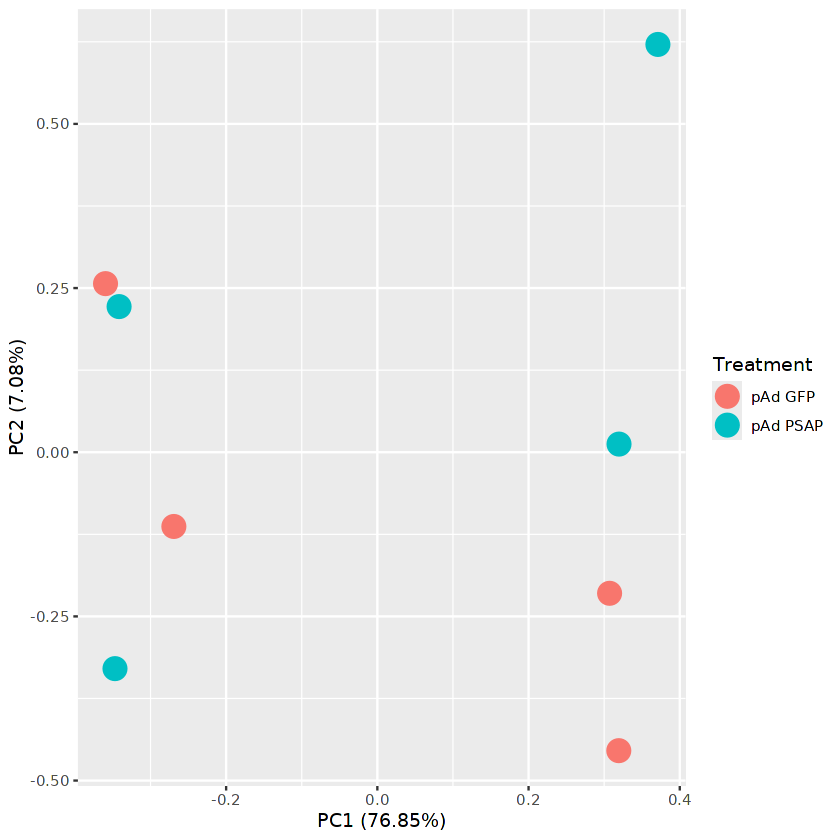

In [20]:
pca_counts <- prcomp(t(rlogcounts))
autoplot(pca_counts, data = samples, colour="Treatment", size=6) #commented this out

Plots can be output as above, or also saved as pdf or image files, as below. Try to navigate and click to the created file, after you run the code. 

Tiff files can also be created this way.

In [21]:
pdf("data/gene_counts/PCA_Plot.pdf")
autoplot(pca_counts, data = samples, colour="Treatment", size=6)
dev.off()

tiff("data/gene_counts/PCA_Plot.tiff")
autoplot(pca_counts, data = samples, colour="Treatment", size=6)
dev.off()    

pdf 
  2

pdf 
  2

### STEP 7: Contrast Comparisons

Contrast comparisons between two treatment groups can be performed using the deseq2 tool to identify differentially up and down regulated genes.

Using R, these results can be summarized, reordered, and/or trimmed.

Differentially expressed genes are typically quantified as those genes which have an adjusted P value of below 0.05. An adjusted P value is also sometimes referred to as a false discovery rate, or FDR. In the below, there are 1357 differentially expressed genes. For the sake of reducing the amount of differentially expressed genes, to make analyses easier, these could also be further refined by introducing a threshold based on fold-change. DEseq2 uses the Wald and Benjamini-Hochberg tests for determining P and Adjusted P values, respectively. More information on this can be found in the DEseq2 documentation. 

In [22]:
#Output the results of comparing WT and BPs_lysogen group
res_PSAP_GFP <- results(deseq2Data, contrast=c("Treatment","pAd PSAP","pAd GFP"))
summary(res_PSAP_GFP)
print("Number of genes under a p value of 0.05")
sum(res_PSAP_GFP$pvalue < 0.05, na.rm=TRUE)
print("Number of genes under a p adjusted value of 0.05")
sum(res_PSAP_GFP$padj < 0.05, na.rm=TRUE)


#deseq2 optionally output some padj values as 'NA' when genecounts meet certain criteria
#that criteria can be found here: https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA
#for practical uses, one could replace the NA values with '1', essentially NA values not significant.
res_PSAP_GFP$padj[is.na(res_PSAP_GFP$padj)] <- 1


out of 19067 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.0052%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 4, 0.021%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Number of genes under a p value of 0.05"


[1] 142

[1] "Number of genes under a p adjusted value of 0.05"


[1] 1

### STEP 8: Annotating and Exporting Results

These differentially expressed genes can be annotated and exported.

Combining gene counts with gene annotation isn't always simple, and will vary heavily depending on the annotation file itself.

For example, when merging genecounts by 'gene id' with feature tables from NCBI's assembly database, its very common to have duplicate rows, as a single 'gene id' may match to multiple features. 

Depending on how you want to use your annotated results, you may decide to further reformat your table in whatever suits your further analysis best, for instance by downloading and using a spreadsheet editor.

Because the transcript table for m chelonae we have here is so simple, and contains essentially only one 'CDS' or '..RNA' feature for every gene identifier we are using, it is easy for us to reformat it here in the way we want just using R code. However, it is important to note that, again, this is very often not the case, and reformatting will vary depending on both the annotation file itself, and what that annotation file will be used for.

In [26]:
#read-in the annotation file (see extended tutorial for more info on how to get annotation files) and store it into a variable.
annotation <- read.table("data/reference/mouse_feature_table.txt", header=TRUE,sep='\t', quote="\"",comment.char = "")
#put the previous deseq results into an easier to manipulate data.frame format
results <- data.frame(res_PSAP_GFP)
#merge the annotation with the deseq2 contrast comparison table
results.annot <- merge(results,annotation,by.x=0,by.y=17,all.x=TRUE)

#Open the annotation file above to see the format. If you further download and examine in a spreadsheet editor,
#you can see there is one CDS or ..RNA identifier for each 'gene' feature
#this makes reformatting in R simple by just removing every 'gene' feature, and leaving the more detailed 'cds' or '...RNA' feature.
#this is very often not always the case, but simple and easy here.
results.annot <- results.annot[annotation$X..feature!='gene',]

#labeling the columns properly after the merge
colnames(results.annot)[1] <- 'locus_tag'

#write out the file
write.table(results.annot,"data/gene_counts/PSAP_GFP_DESeq2_annot.txt",row.names=FALSE,sep="\t")

head(results.annot)


,locus_tag,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,X..feature,class,assembly,⋯,strand,product_accession,non.redundant_refseq,related_accession,name,symbol,GeneID,feature_interval_length,product_length,attributes
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
2,ENSMUSG00000000028,102.863349,0.114176029,0.20300387,0.5624328,0.5738212,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,ENSMUSG00000000037,37.945441,-0.007916597,0.28687585,-0.0275959,0.9779845,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,ENSMUSG00000000049,1.550805,1.330193497,1.68304911,0.7903474,0.4293249,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,ENSMUSG00000000056,3403.672718,-0.020584466,0.09489877,-0.2169097,0.8282787,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,ENSMUSG00000000058,10485.646110,0.071276207,0.29783393,0.2393153,0.8108611,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
10,ENSMUSG00000000088,7744.614591,-0.022437673,0.19403843,-0.1156352,0.9079417,0.9999867,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### STEP 9: More Plots and Clustering Data

Finally, although several other different kind of analysis can be done, it is common to plot the results of differential gene expression analysis in forms such as volcano, MA, and heatmaps. These plots help one to further examine the output list of differentially expressed genes in different ways, and potentially identify or further investigate candidate gene(s).

ERROR: Error in plotMA(results_volc_df): Error from the generic function 'plotMA' defined in package 'BiocGenerics': no S4 method definition for argument 'results_volc_df' of class 'data.frame' was found. Did you perhaps mean calling the function 'plotMA' from another package, e.g. 'limma'? In that case, please use the syntax 'limma::plotMA'.


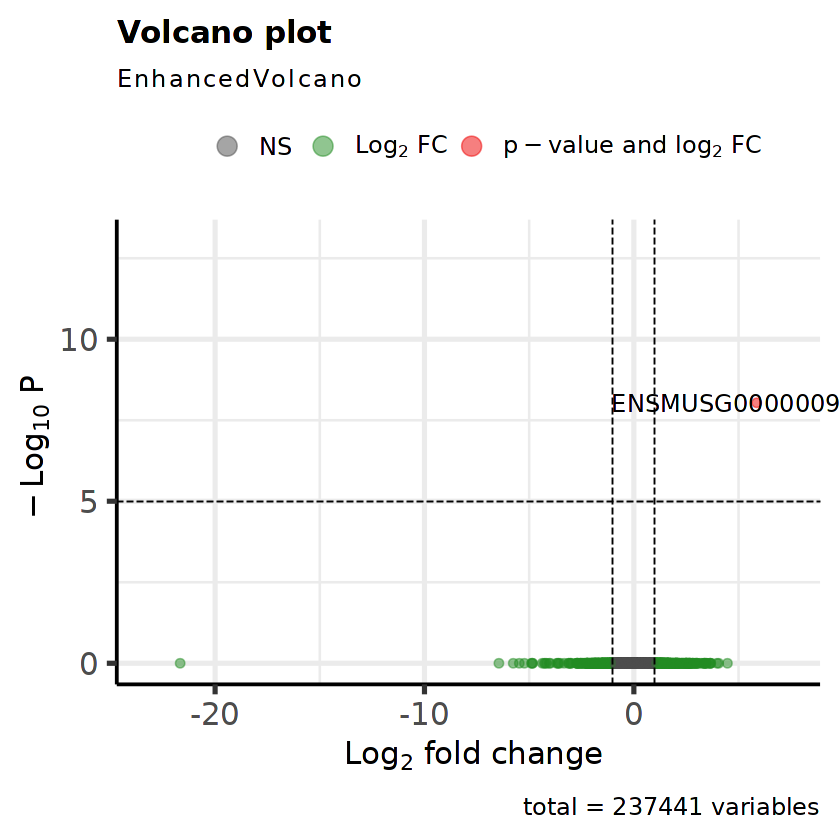

In [28]:
#volcano and ma plots can be used to visualize significant differences in gene expression
results_volc_df <- results.annot
EnhancedVolcano(results_volc_df,
    lab = results_volc_df[,1],
    x = 'log2FoldChange',
    y = 'padj')

#ma plot
plotMA(res_WT_BPs) #throws error


#heatmaps can used to look at clustering and expression of various gene lists.
filtered_res <- results.annot %>% filter(padj < 0.05)
filtered_res_counts <- subset(rlogcounts, rownames(rlogcounts) %in% filtered_res[,1])
filtered_res_counts = t(scale(t(filtered_res_counts)))
Heatmap(filtered_res_counts[1:50,], name = "Z-Score", row_names_gp = gpar(fontsize = 8))